# Experiments with strategies on a random walk

Let's see if we can lock in wins and avoid losses, even if the stockmarket is modelled as a pure random walk

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

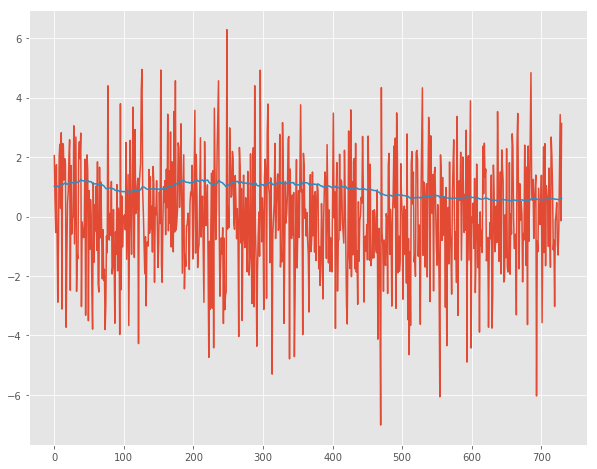

In [51]:
# Normal distribution with std 2
# First thing to check: How does this assumption fit reality?

valuation_changes = np.random.randn(730) * 2
valuations_cum = np.cumprod((valuation_changes / 100) + 1)

plt.gcf().set_size_inches(10,8)
plt.plot(valuation_changes)
plt.plot(valuations_cum)

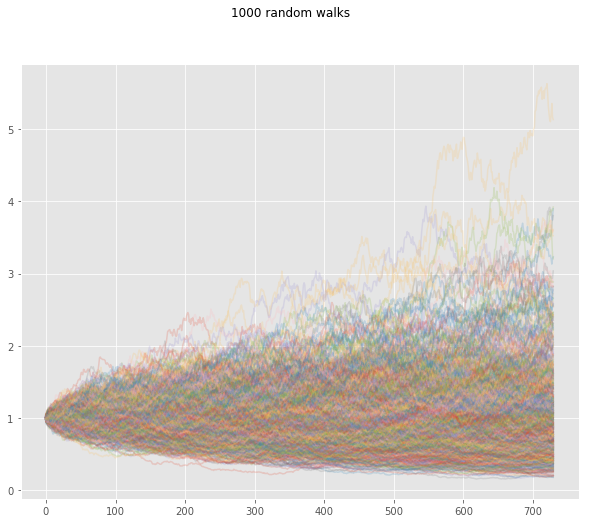

In [83]:
n = 1000
random_walks = []
f = plt.figure(figsize=(10,8))
f.suptitle('1000 random walks')

for i in range(n):
    valuation_changes = np.random.randn(730) * 2
    valuations_cum = np.cumprod((valuation_changes / 100) + 1)
    random_walks.append(valuations_cum)
    
    plt.plot(valuations_cum, alpha=0.2)
    

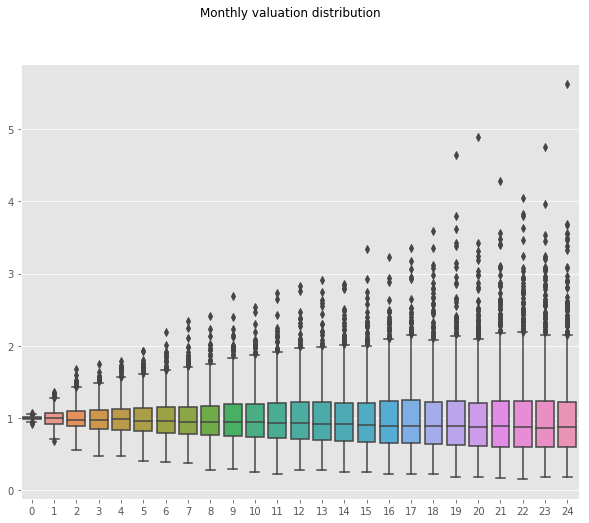

In [85]:
days = list(zip(*random_walks))
f = plt.figure(figsize=(10,8))
f.suptitle('Monthly valuation distribution')

months = []
for n in range(0,730,30):
    months.append(days[n])

sns.boxplot(data=months)

In [118]:
dates = pd.date_range('1/1/2001', periods= 730)
valuation_changes = pd.Series((np.random.randn(len(dates)) * 2 / 100) + 1, index=dates)
valuations_cum = np.cumprod(valuation_changes)
df = pd.DataFrame({'price_change' : valuation_changes, 'price' : valuations_cum})
df.head()

,price,price_change
2001-01-01,0.982016,0.982016
2001-01-02,0.986937,1.005011
2001-01-03,0.971047,0.983900
2001-01-04,0.972752,1.001756
2001-01-05,0.996435,1.024346


In [117]:
# Strategy 1: Buy 100 units every day, sell everything when 10% up
threshold = 1.1

df['purchases'] = 100 / df['price'] 
df['purchased'] = df['purchase'].cumsum()
df['spent'] = (df['purchase'] * df['price']).cumsum()

df['rentability'] = df['purchased'] * df['price'] / df['spent']
df['sell'] = df['rentability'] > threshold  
df['sales'] = df['sell'].map(lambda b: 1.0 if b else 0) 


In [275]:
# Holdings are holdings at the end of the day
# Prices are in units of currency / units of stock
# Holdings are in    units of stock
# Price_paid is in   unit of currency
# daily_buy is in    unit of currency

def strategy_1(df, threshold = 1.1, daily_buy=100):    
    working_copy = df.copy().reindex(columns=['price', 'price_change', 'rentability', 
                                              'purchases', 'sales', 'holdings', 
                                              'cash_paid', 'cash', 'overall_return'])
    
    for index, day in working_copy.iterrows():
        # Set up the framework on the first day:
        if index == working_copy.iloc[0].name:
            day_0 = day
            day_0['rentability'] = np.nan
            day_0['purchases'] = daily_buy / day_0['price']
            day_0['holdings'] = day_0['purchases']
            day_0['cash_paid'] = day_0['purchases'] * day_0['price']
            day_0['sales'] = 0
            day_0['cash'] = 0
            
            working_copy.loc[index] = day_0
            continue
        
        # For every day after the first (works at least for integer and datetime indexes):
        prev_day = working_copy.loc[index - 1]
        day['rentability'] = prev_day['holdings'] * day['price'] / prev_day['cash_paid']
        
        if day['rentability'] > threshold:
            # Sell
            day['purchases'] = 0
            day['sales'] = prev_day['holdings']
            day['cash_paid'] = 0 # Reset rentability    prev_day['cash_paid']

        else:
            # Buy
            day['purchases'] = daily_buy / day['price']
            day['sales'] = 0
            day['cash_paid'] = prev_day['cash_paid'] + day['purchases'] * day['price']
            
        day['cash'] = day['sales'] * day['price'] + prev_day['cash']
        day['holdings'] = day['purchases'] + prev_day['holdings'] - day['sales']
        
    working_copy['overall_return'] = (working_copy['cash'] + working_copy['holdings'] * working_copy['price']) / working_copy['purchases'].cumsum()
    return working_copy

In [276]:
results = strategy_1(df)

/home/dani/anaconda3/envs/turbogarbanzo/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


In [283]:
results.head()

,price,price_change,rentability,purchases,sales,holdings,cash_paid,cash,overall_return
2001-01-01,0.982016,0.982016,NaN,101.831339,0.0,101.831339,100.0,0.0,0.982016
2001-01-02,0.986937,1.005011,1.005011,101.323639,0.0,203.154978,200.0,0.0,0.986937
2001-01-03,0.971047,0.983900,0.986365,102.981640,0.0,306.136618,300.0,0.0,0.971047
2001-01-04,0.972752,1.001756,0.992650,102.801083,0.0,408.937702,400.0,0.0,0.972752
2001-01-05,0.996435,1.024346,1.018700,100.357763,0.0,509.295465,500.0,0.0,0.996435


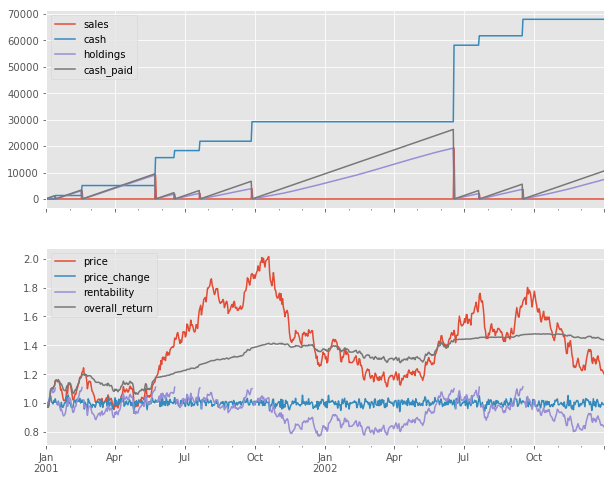

In [285]:
figure, axes = plt.subplots(2,1,figsize=(10,8), sharex=True)

results[['sales', 'cash', 'holdings', 'cash_paid']].plot(ax=axes[0])
axes[0].legend()
results[['price', 'price_change', 'rentability', 'overall_return']].plot(ax=axes[1])
plt.show()